In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd 

train = pd.read_csv('/Users/emilyvincett/downloads/home-data-for-ml-course/train.csv')
test = pd.read_csv('/Users/emilyvincett/downloads/home-data-for-ml-course/test.csv')
X = train.iloc[:,:-1]
y = train.iloc[:,-1]

#X.info()
features_to_drop = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature']
X = X.drop(features_to_drop,axis=1)
test = test.drop(features_to_drop,axis=1)
X_categorical_col = pd.get_dummies(X.select_dtypes(include='object'))
test_categorical_col = pd.get_dummies(test.select_dtypes(include='object'))
X_categorical_col = X_categorical_col[test_categorical_col.columns]
xcc = X_categorical_col.reset_index()
tcc = test_categorical_col.reset_index()
X = X.reset_index()
X = X.merge(xcc, left_on='index',right_on='index').select_dtypes(include='number')
test = test.reset_index()
test = test.merge(tcc, left_on='index',right_on='index').select_dtypes(include='number')
X = X.drop('index',axis=1)
test = test.drop('index',axis=1)
X = X.fillna(method='pad')
test = test.fillna(method='pad')
X.shape,test.shape

((1460, 255), (1459, 255))

In [2]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=0)

best_features = SelectKBest(f_regression,k='all')
picks = best_features.fit(X_train,y_train)
picks_df = pd.DataFrame(picks.scores_,index=X.columns)
features = picks_df.sort_values(0,ascending=False).dropna()[:125].index
features_2 = picks_df.sort_values(0,ascending=False).dropna()[:60].index
X_tr_sel = X_train[features]
X_te_sel = X_test[features]
X_tr_sel_2 = X_train[features_2]
X_te_sel_2 = X_test[features_2]

#Zip this back for submission 
t_id = test['Id']
te_sel = test[features]

rf3 = RandomForestRegressor(random_state=0)

grid_values = {'n_estimators':[100,1000],
               'max_depth':[5,20,50],
               'max_features':['auto','sqrt','log2']
              }
grid_rf3_mse = GridSearchCV(rf3,param_grid=grid_values,scoring='neg_mean_squared_error',n_jobs=-1,cv=5)
results_3 = grid_rf3_mse.fit(X_tr_sel_2,y_train)
predictions_3 = grid_rf3_mse.predict(X_te_sel_2)

print('Model 3 Best Score %f using %s' %(results_3.best_score_, results_3.best_params_))
print ('Model Best MSE score %f' %(mean_squared_error(y_test, predictions_3)))

# My analyses suggests that as the number of features increases the greater the number of estimators 
# and lower the max_depth
# As number of features decrease number of estimators reduce but up to a point after 
# which they start to increase again. 

Model 3 Best Score -899646597.890263 using {'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 1000}
Model Best MSE score 916770233.913242


In [3]:
# Best performing model with 60 features - use this as a baseline for next models. 

te_sel_2 = test[features_2]
test_predictions_2 = grid_rf3_mse.predict(te_sel_2)
test_predictions_2 = list(test_predictions_2)
preds_2 = pd.DataFrame(list(zip(t_id,test_predictions_2)))
preds_2 = preds_2.rename({0:'Id',1:'SalePrice'},axis=1)
filename = 'House_price_predictions_2'
preds_2.to_csv(filename,index=False)
print('Saving file '+ filename)

Saving file House_price_predictions_2


In [4]:
#### Gradient Boosting Model - Doesn't perform as well as the random forest with 60 features. 

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

gb = GradientBoostingRegressor(random_state=0)
grid_values = {'learning_rate':[0.01,0.1],
               'n_estimators':[150,1000],
               'criterion':['mae']}

grid_gb_mse = GridSearchCV(gb, param_grid=grid_values,scoring='neg_mean_squared_error', n_jobs=-1,cv=5)
results  = grid_gb_mse.fit(X_tr_sel_2,y_train)
predictions = grid_gb_mse.predict(X_te_sel_2)

print ('Models Best Score %f using %s' %(results.best_score_, results.best_params_))
print('Models MSE Score %f' %(mean_squared_error(y_test,predictions)))

test_predictions = grid_gb_mse.predict(te_sel_2)
test_predictions = list(test_predictions)

pred_gb = pd.DataFrame(list(zip(t_id,test_predictions)))
pred_gb = pred_gb.rename({0:'Id', 1:'SalePrice'},axis=1)
pred_gb

filename = 'House Price Gradient.csv'
pred_gb.to_csv(filename, index=False)
print('Saving file' + filename)

Models Best Score -940106169.626521 using {'criterion': 'mae', 'learning_rate': 0.1, 'n_estimators': 150}
Models MSE Score 829184772.451697
Saving fileHouse Price Gradient.csv


Model Best Score -1208335486.922832 using {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 3000}
Model Best Mse score 1380909396.223803


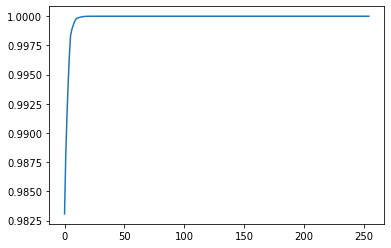

In [42]:
# PCA 

from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt 

# Define the PCA object 
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

pca = PCA(n_components=30)

pca.fit(X)
X_pca = pca.transform(X)

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, random_state=0)

rf_pca = RandomForestRegressor(random_state=0)

grid_values = {'n_estimators':[100,3000],
               'max_depth':[5,20,50],
               'max_features':['auto','sqrt','log2']
              }
    

grid_rf_pca_mse = GridSearchCV(rf_pca, param_grid=grid_values, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
result_pca = grid_rf_pca_mse.fit(X_train_pca,y_train)
predictions = grid_rf_pca_mse.predict(X_test_pca)

print('Model Best Score %f using %s'%(result_pca.best_score_,result_pca.best_params_))
print('Model Best Mse score %f' %(mean_squared_error(y_test, predictions)))

In [45]:
gb_pca = GradientBoostingRegressor(random_state=0)

grid_values = {'learning_rate':[0.001, 0.01,0.1],
               'n_estimators':[150,1000, 2000]}

grid_gb_pca_mse = GridSearchCV(gb_pca, param_grid=grid_values, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
results = grid_gb_pca_mse.fit(X_train_pca,y_train)
predictions = grid_gb_pca_mse.predict(X_test_pca)

print('Model Best Score %f using %s'%(results.best_score_,results.best_params_))
print('Model Best Mse score %f' %(mean_squared_error(y_test, predictions)))

Model Best Score -1183918444.783442 using {'learning_rate': 0.1, 'n_estimators': 150}
Model Best Mse score 1286759652.900250
